In [0]:
#Priya Rajpurohit 2015073
#Sakshi Saini 2017092

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.layers.core import Layer
import keras.backend as K

from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

import cv2  
from keras import backend as K 
from keras.utils import np_utils

import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
ds = tfds.load("plant_village", split=tfds.Split.TRAIN, batch_size=-1)
ds = tfds.as_numpy(ds)

images, labels = ds["image"], ds["label"]


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/plant_village/1.0.0.incompleteL50KVS/plant_village-train.tfrecord


Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.0. Subsequent calls will reuse this data.


(38012, 256, 256, 3) (16291, 256, 256, 3)


In [0]:
images, labels = ds["image"], ds["label"]
n1 = 224
m1 = 224

images_gray=[]

for i in range(20000):
  img = images[i]
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
  img = cv2.resize(img, (n1,m1))

  images_gray.append(img)


In [0]:
images_gray = np.array(images_gray)

X_train, X_test, y_train, y_test = train_test_split( images_gray[:20000], labels[:20000], test_size=0.3, random_state=42 )
print(X_train.shape, X_test.shape)

(14000, 224, 224, 3) (6000, 224, 224, 3)


In [0]:
np.unique(y_train).shape
n = 38

y_train = np_utils.to_categorical( y_train, n)
y_test = np_utils.to_categorical( y_test, n)

X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
   

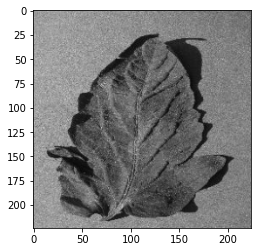

In [0]:
plt.imshow(images_gray[0])

In [0]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output
    

In [0]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)


In [0]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(38, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(38, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(38, activation='softmax', name='output')(x)


In [0]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')


In [0]:
model.summary()


Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 56, 56, 64)   4160        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

In [0]:
epochs = 25
initial_lrate = 0.005

def decay(epoch, steps=100):
    initial_lrate = 0.005
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=True)
lr_sc = LearningRateScheduler(decay, verbose=1)
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

(14000, 38)

In [0]:
history = model.fit(X_train, [y_train, y_train, y_train], validation_data=(X_test, [y_test, y_test, y_test]), epochs=epochs, batch_size=24, callbacks=[lr_sc])


Train on 14000 samples, validate on 6000 samples
Epoch 1/25

Epoch 00001: LearningRateScheduler setting learning rate to 0.005.
14000/14000 [==============================] - 400s 29ms/step - loss: 5.3972 - output_loss: 3.3757 - auxilliary_output_1_loss: 3.3576 - auxilliary_output_2_loss: 3.3813 - output_accuracy: 0.1130 - auxilliary_output_1_accuracy: 0.1206 - auxilliary_output_2_accuracy: 0.1124 - val_loss: 5.0086 - val_output_loss: 3.1414 - val_auxilliary_output_1_loss: 3.0840 - val_auxilliary_output_2_loss: 3.1400 - val_output_accuracy: 0.1803 - val_auxilliary_output_1_accuracy: 0.1975 - val_auxilliary_output_2_accuracy: 0.1800
Epoch 2/25

Epoch 00002: LearningRateScheduler setting learning rate to 0.005.
14000/14000 [==============================] - 399s 28ms/step - loss: 4.8301 - output_loss: 3.0341 - auxilliary_output_1_loss: 2.9604 - auxilliary_output_2_loss: 3.0276 - output_accuracy: 0.1961 - auxilliary_output_1_accuracy: 0.2236 - auxilliary_output_2_accuracy: 0.2054 - val_lo

In [0]:
final_accuracy = history.history["val_output_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

FINAL ACCURACY MEAN-5:  0.8851333379745483


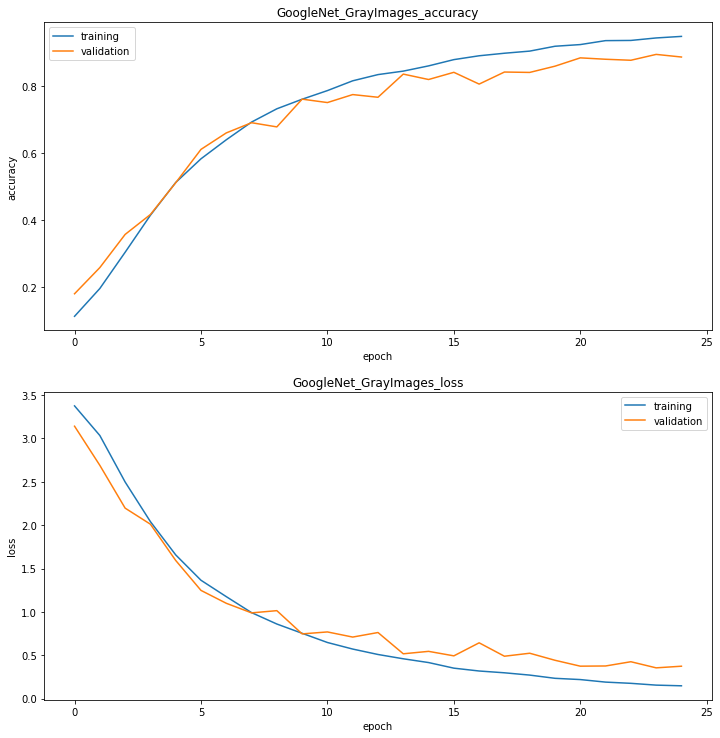

In [0]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('GoogleNet_GrayImages_'+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['output_accuracy'], history.history['val_output_accuracy'], 'accuracy', 211)
display_training_curves(history.history['output_loss'], history.history['val_output_loss'], 'loss', 212)


In [0]:
!mkdir -p saved_model
model.save('saved_model/my_model') 


In [0]:
history.history

{'auxilliary_output_1_accuracy': [0.12057143,
  0.22357143,
  0.32378572,
  0.43364286,
  0.5215,
  0.5837857,
  0.6255,
  0.6615,
  0.69185716,
  0.71842855,
  0.74128574,
  0.76207143,
  0.7797143,
  0.7947143,
  0.80471426,
  0.82685715,
  0.8330714,
  0.8467857,
  0.852,
  0.86064285,
  0.87371427,
  0.8800714,
  0.87857145,
  0.88928574,
  0.89692855],
 'auxilliary_output_1_loss': [3.3576229,
  2.9603808,
  2.4879987,
  2.0294807,
  1.6694975,
  1.4271829,
  1.2550026,
  1.1074152,
  1.0052087,
  0.917136,
  0.8249929,
  0.755362,
  0.69378924,
  0.6379119,
  0.5980213,
  0.5328357,
  0.49834222,
  0.46961352,
  0.44175798,
  0.41455066,
  0.38131052,
  0.35808977,
  0.34701604,
  0.324551,
  0.3003082],
 'auxilliary_output_2_accuracy': [0.11242857,
  0.20542857,
  0.32221428,
  0.43392858,
  0.5137143,
  0.5830714,
  0.62142855,
  0.6692857,
  0.7015,
  0.73535717,
  0.7567857,
  0.78307146,
  0.8000714,
  0.8122857,
  0.825,
  0.83935714,
  0.85242856,
  0.859,
  0.87207144,
  0

In [0]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")


In [0]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 


# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
